# Find Phone

## Project Requirements
- Detect the phone from the given photos.

## Software Requirements
- Anaconda
- conda specfile is in the main directory(spec-file.txt)
- Use this command `conda install --name myenv --file spec-file.txt` to create an environment
- Then run `jupyter notebook` from the terminal
- use the browser to open up `localhost:8888`(Default)
- You can run the `FindPhone.ipynb` notebook to see the methods I used.
- To just run the final trained model you can use `python detectPhone.py input_image output_image`

## References
- [Interesting Blog about using the TensorFlow Object Detection API](https://towardsdatascience.com/how-to-train-your-own-object-detector-with-tensorflows-object-detector-api-bec72ecfe1d9)
- [Step By Step Guide in using Tensorflow Object Detection API](https://medium.com/@WuStangDan/step-by-step-tensorflow-object-detection-api-tutorial-part-1-selecting-a-model-a02b6aabe39e)

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np

def draw_box(x,y,file):
    img = plt.imread("find_phone/"+file)
    x = int(x*img.shape[1])
    y = int(y*img.shape[0])
    cv2.rectangle(img, (x-30, y-30), (x+30, y+30), (0, 255, 0), 2)
    return img



def create_tf_params(x,y,file):
    img = plt.imread("find_phone/"+file)
    x = int(x*img.shape[1])
    y = int(y*img.shape[0])
    offset_x = 30/img.shape[1]
    offset_y = 30/img.shape[0]
    x_max = [x+offset_x]
    x_min = [x-offset_x]
    y_max = [y+offset_y]
    y_min = [y-offset_y]
    return img

file    107.jpg
x        0.2327
y        0.4724
Name: 124, dtype: object
(326, 490, 3)


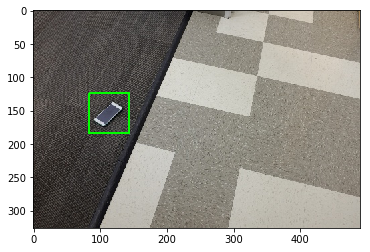

In [2]:
columns = ["file","x","y"]
df = pd.read_csv("find_phone/labels.txt",header=None, delimiter=r"\s+",names=columns)
df = df.sort_values("file")
print(df.iloc[10])
img = plt.imread("find_phone/12.jpg")
print(img.shape)
test_data = df.iloc[10]
img = draw_box(test_data["x"],test_data["y"],test_data["file"])
plt.imshow(img)
#df.describe()

# Creating TFRecord

This creates the data needed for the object detection API. It converts the image into tfrecord. We can use this format to leverage the pretrained models.

In [13]:
import tensorflow as tf
from utils import dataset_util

In [14]:
def create_tf_example(data):
    
    x,y,file = data["x"],data["y"],data["file"]
    filename = "find_phone/"+file
    img = plt.imread(filename)
    with tf.gfile.GFile(filename, 'rb') as fid:
        encoded_image = fid.read()
    #print(filename)
    filename = filename.encode()
    image_format = b'jpg'
    width = int(x*img.shape[1])
    height = int(y*img.shape[0])
    offset_x = 30/img.shape[1]
    offset_y = 30/img.shape[0]
    xmaxs = [x+offset_x]
    xmins = [x-offset_x]
    ymaxs = [y+offset_y]
    ymins = [y-offset_y]
    class_name = 'Phone'
    classes = [1]
    bounding_box = [xmins,ymins,xmaxs,ymaxs]
    bounding_boxes.append(bounding_box)
    one_hot_class = to_one_hot(class_name) #add one hot
    one_hot_classes.append(one_hot_class)
    bounding_boxes = np.asarray(bounding_boxes)
    one_hot_classes = np.asarray(one_hot_classes)
    image_data = np.hstack((bounding_boxes, one_hot_classes))
    data[image_name] = image_data
    return tf_example

In [ ]:
for filename in filenames:
    tree = ElementTree.parse(self.path_prefix + filename)
    root = tree.getroot()
    bounding_boxes = []
    one_hot_classes = []
    size_tree = root.find('size')
    width = float(size_tree.find('width').text)
    height = float(size_tree.find('height').text)
    for object_tree in root.findall('object'):
        for bounding_box in object_tree.iter('bndbox'):
            xmin = float(bounding_box.find('xmin').text)/width
            ymin = float(bounding_box.find('ymin').text)/height
            xmax = float(bounding_box.find('xmax').text)/width
            ymax = float(bounding_box.find('ymax').text)/height
        bounding_box = [xmin,ymin,xmax,ymax]
        bounding_boxes.append(bounding_box)
        class_name = object_tree.find('name').text
        one_hot_class = self._to_one_hot(class_name)
        one_hot_classes.append(one_hot_class)
    image_name = root.find('filename').text
    bounding_boxes = np.asarray(bounding_boxes)
    one_hot_classes = np.asarray(one_hot_classes)
    image_data = np.hstack((bounding_boxes, one_hot_classes))
    self.data[image_name] = image_data

In [15]:
def create_data(input_file,test_data_name,train_data_name):
    columns = ["file","x","y"]
    df = pd.read_csv(input_file,header=None, delimiter=r"\s+",names=columns)
    df = df.sort_values("file")
    msk = np.random.rand(len(df)) < 0.8
    train = df[msk]
    test = df[~msk]
    
    writer = tf.python_io.TFRecordWriter(train_data_name)
    
    for ind,data in train.iterrows():
        tf_example = create_tf_example(data)
        writer.write(tf_example.SerializeToString())

    writer.close()

    writer = tf.python_io.TFRecordWriter(test_data_name)
    
    for ind,data in test.iterrows():
        tf_example = create_tf_example(data)
        writer.write(tf_example.SerializeToString())

    writer.close()
    

In [16]:
create_data("find_phone/labels.txt","phone_test.record","phone_train.record")

# Configuring the Model

The configuration files are modified according to the needs, 
- We just have one label in this dataset. So I created the the label pbtxt (`phone_label_map.pbtxt` in `models/research/data/phone_label_map.pbtxt`)
- I used the [SSD_MOBLENET_V1_COCO model](https://research.googleblog.com/2017/06/supercharge-your-computer-vision-models.html) as the starting point for this model. This brings in the knowledge of all the pretrained datasets. It helps our case because we dont have much data.
- I even configured the model for more data augmentation(ssd_random_crop,random_black_patches,random_jitter_boxes,scale_boxes_to_pixel_coordinates,random_rotation90). So the model gets trained better.


Before configuring the model, run `protoc object_detection/protos/*.proto --python_out=.` from models/research directory.

Download the Pretrained Model from [Tensorflow Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) 

Start training the model using this command.(from models/research)


- You can see the progress using TensorBoard
- I trained it for 200 epochs and seems to have good accuracy around 95-96%. So I stopped the training at that time.

Looks like the model performs well at this state. 

In [1]:
"""python object_detection/train.py \
    --logtostderr \
    --pipeline_config_path="/home/surjith/find_phone/ssd_keras/models/research/object_detection/models/phone_detection/ssd_mobilenet_v1_phone.config" \
    --train_dir="/home/surjith/find_phone/ssd_keras/models/research/object_detection/data/" """

'python object_detection/train.py     --logtostderr     --pipeline_config_path="/home/surjith/find_phone/ssd_keras/models/research/object_detection/models/phone_detection/ssd_mobilenet_v1_phone.config"     --train_dir="/home/surjith/find_phone/ssd_keras/models/research/object_detection/data/" '

# Export the trained Model
Using the following command I exported the model as a fine tuned model.


In [2]:
"""python object_detection/export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path /home/surjith/find_phone/ssd_keras/models/research/object_detection/models/phone_detection/ssd_mobilenet_v1_phone.config \
    --trained_checkpoint_prefix /home/surjith/find_phone/ssd_keras/models/research/object_detection/data/model.ckpt-236 \
    --output_directory /home/surjith/find_phone/ssd_keras/models/research/object_detection/data/fine_tuned_model/"""

'python object_detection/export_inference_graph.py     --input_type image_tensor     --pipeline_config_path /home/surjith/find_phone/ssd_keras/models/research/object_detection/models/phone_detection/ssd_mobilenet_v1_phone.config     --trained_checkpoint_prefix /home/surjith/find_phone/ssd_keras/models/research/object_detection/data/model.ckpt-236     --output_directory /home/surjith/find_phone/ssd_keras/models/research/object_detection/data/fine_tuned_model/'

In [4]:
import os
os.system("python predict.py -i test_data/0.jpg -o out1.jpg")

0

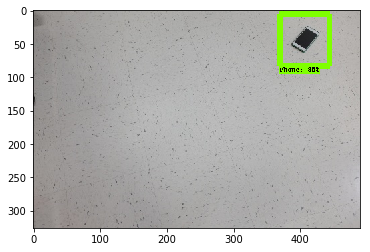

In [7]:
img = plt.imread("out1.jpg")
plt.imshow(img)

# Final Solution
Use predict.py for predicting the image input. Use `python -i "input_image" -o "output_image"`